##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [1]:
#%pip install pandas 
#%pip install matplotlib
#%pip install scikit-learn
#%pip install seaborn
import sklearn as sk
from sklearn import datasets
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier 
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [2]:
# Can have as many cells as you want for code
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

df = pd.read_parquet(filepath)

cols_df1 = df.columns[:8]  
cols_df2 = df.columns[8:18]  
cols_df3 = df.columns[18:24] 
cols_df4 = df.columns[24:34]  
cols_df5 = df.columns[34:41] 
cols_df6 = df.columns[41:158]  
cols_df7 = df.columns[158:303] #will be removed
cols_df8 = df.columns[303:] 

df1 = df[cols_df1]
df2 = df[cols_df2]
df3 = df[cols_df3]
df4 = df[cols_df4]
df5 = df[cols_df5]
df6 = df[cols_df6]
df7 = df[cols_df7]
df8 = df[cols_df8]

df1 = df1.drop(columns=df1.columns[:2])
df3 = df3[df3.columns[2:3]]
df3 = df3[df3.columns[2:3]]
df4 = df4.iloc[:, [0, 1, 2, 8, 9]]
df5 = df5.drop(columns = ['recency_cancel'])
df6 = df6.drop(columns=df6.columns[96:103])
df6 = df6.astype('float')


In [3]:
#combining columns in cat 6 based on ape, sumins and prempaid

ape_av = df6.columns[0:30].to_list() + df6.columns[89:96].to_list()
df6['av_ape'] = df6[ape_av].mean(axis=1)
df6 = df6.drop(columns=ape_av)

sumins_av = df6.columns[0:29].to_list() + df6.columns[59:66].to_list()
df6['av_sumins'] = df6[sumins_av].mean(axis=1)
df6 = df6.drop(columns=sumins_av)

prempaid_av = df6.columns[0:37]
df6['av_prempaid'] = df6[prempaid_av].mean(axis=1)
df6 = df6.drop(columns=prempaid_av)

df = pd.concat([df1, df2, df3, df4, df5, df6, df8], axis=1)
df.columns.get_loc("f_purchase_lh")
df = df.drop_duplicates()
df = df.drop('min_occ_date', axis=1)


### Dealing with missing data


In [4]:
# Detecting NaN and None

null = pd.isnull(df)
null.head()

# Filling null values

df.fillna(0)
df['recency_lapse'] = df['recency_lapse'].fillna(0)

#Count the total number of missing values
pd.isnull(df).sum().sum()

#dropped irrelevant/unhelpful rows
for x in df.index:
    if df.loc[x, "ctrycode_desc"] == "Not Applicable":
        df.drop(x, inplace=True)
        
df = df.dropna(subset=["annual_income_est"])
  

#knn for income
income = df['annual_income_est']
income.value_counts()
df["annual_income_est"][13:14]


csv_output = "./data/catB_train.csv" 
df.to_csv(csv_output, index = False)

#df = df.interpolate(method='pad')
df["f_purchase_lh"] = df["f_purchase_lh"].fillna(0)


## Feature Selection

In [14]:
#correlation between target and av_ape


print(df["av_ape"].corr(df["f_purchase_lh"]))
print(df["av_sumins"].corr(df["f_purchase_lh"]))
print(df["av_prempaid"].corr(df["f_purchase_lh"]))



0.03821129138367707
0.07797179764325325
0.05211409848793196


In [15]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

#converting categorical to numerical
dummy_date = '1970-01-01'
df['cltdob_fix'] = df['cltdob_fix'].replace('None', dummy_date)
df['cltdob_fix'] = pd.to_datetime(df['cltdob_fix']).dt.year % 100

df['cltsex_fix'] = df['cltsex_fix'].map({'Male': 0, 'Female': 1})
df["cltsex_fix"] = df["cltsex_fix"].fillna(0)

df['hh_size_est'] = df['hh_size_est'].map({'1': 1, '2': 2, '3': 3, '4': 4, '>4': 5})
df["hh_size_est"] = df["hh_size_est"].fillna(0)

df['annual_income_est'] = df['annual_income_est'].map({'E.BELOW30K': 1, 'D.30K-60K': 2, 'C.60K-100K': 3, 'B.100K-200K': 4, 'A.ABOVE200K': 5})


In [7]:
#one hot encoding
df = pd.get_dummies(df, columns=['ctrycode_desc', 'clttype', 'stat_flag'])

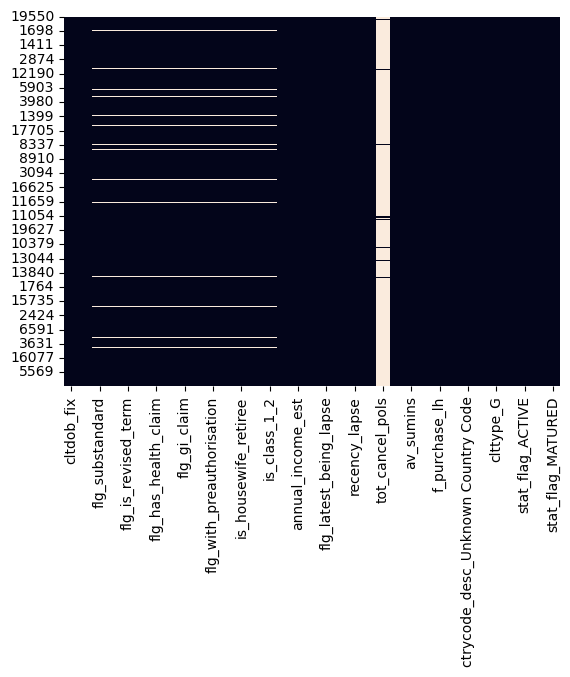

In [8]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()

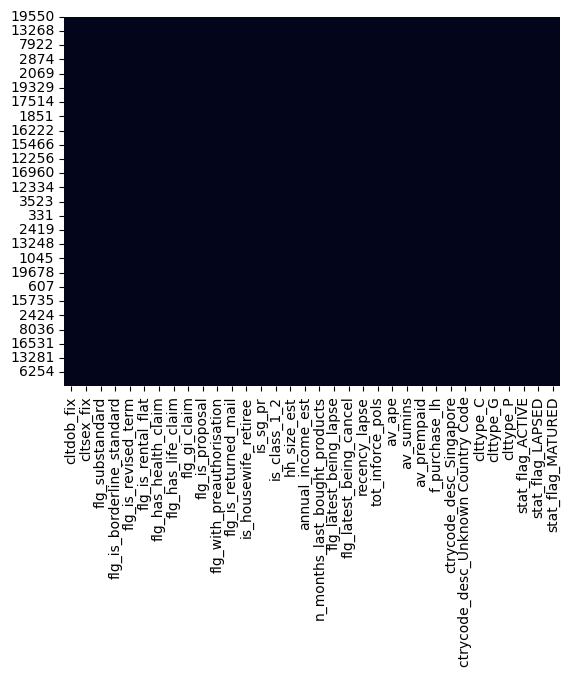

In [9]:
df = df.dropna(subset=["flg_substandard"]) 
df = df.drop(columns = ['tot_cancel_pols']) #more than 50% data is missing
sns.heatmap(df.isnull(), cbar=False)
plt.show() #all NA values have been imputed or removed

In [10]:
y = df["f_purchase_lh"]
X = df.drop(columns = ['f_purchase_lh'])

In [11]:
#decision tree classifier (remove?)
model = DecisionTreeClassifier()
y = df["f_purchase_lh"]
X = df.drop(columns = ['f_purchase_lh'])
model.fit(X, y)

feature_importances = model.feature_importances_

feature_names = df.columns[:-1]
print("Length of feature_names:", len(feature_names))
print("Length of feature_importances:", len(feature_importances))

#(feature_names.shape())

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#print(len(feature_names))
print(feature_importance_df)
model.feature_importances_


Length of feature_names: 33
Length of feature_importances: 33
                               Feature  Importance
17       n_months_last_bought_products    0.168129
0                           cltdob_fix    0.129169
23                           av_sumins    0.113851
24                         av_prempaid    0.108658
20                       recency_lapse    0.105086
22                              av_ape    0.085398
16                   annual_income_est    0.053942
15                         hh_size_est    0.049026
21                    tot_inforce_pols    0.043642
1                           cltsex_fix    0.027752
14                        is_class_1_2    0.015610
31                    stat_flag_ACTIVE    0.012916
8                         flg_gi_claim    0.011399
2                      flg_substandard    0.010124
29                           clttype_G    0.009923
18              flg_latest_being_lapse    0.009169
3           flg_is_borderline_standard    0.009108
13                  

array([1.29168736e-01, 2.77520784e-02, 1.01242113e-02, 9.10757557e-03,
       0.00000000e+00, 2.88271753e-03, 5.84005409e-03, 0.00000000e+00,
       1.13990442e-02, 5.33461998e-03, 7.23686062e-04, 2.39012771e-03,
       5.25368631e-03, 6.30035325e-03, 1.56103192e-02, 4.90255121e-02,
       5.39417889e-02, 1.68128756e-01, 9.16888005e-03, 5.02951431e-03,
       1.05086205e-01, 4.36423696e-02, 8.53978821e-02, 1.13850924e-01,
       1.08658092e-01, 0.00000000e+00, 0.00000000e+00, 1.43063124e-04,
       2.48190323e-03, 9.92331130e-03, 7.19003434e-04, 1.29155860e-02,
       0.00000000e+00])

SMOTE


In [ ]:
#%pip install imblearn
from imblearn.over_sampling import SMOTE


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!